# Tarea registro de imagenes
Posgrado en Ciencia e Ingeniería de la Computación - UNAM

Gibran Zazueta


## 1- Registro Cohete

Importar paquetes y funcion de rotacion

In [2]:
import cv2
import numpy as np
import math
from ipynb.fs.full.rotacion import *
from matplotlib import pyplot as plt


Leer datos de entrada y escalarlos de 0 a 1, para escalar el error

In [3]:
img_or = cv2.imread('Imagenes/cohete_fijo.png')
img_des= cv2.imread('Imagenes/cohete_des.png')

img_des = cv2.cvtColor(img_des, cv2.COLOR_BGR2GRAY) *(1.0/255.0)
img_or = cv2.cvtColor(img_or, cv2.COLOR_BGR2GRAY) *(1.0/255.0)


Funcion de padding para comparar imagenes del mismo alto y ancho

In [4]:
img_desPAD, img_orPAD = padding(img_des, img_or)

Se especifica el incremento de $\theta$ y se calcula el error inicial 

In [5]:
thetaInc = 20
theta=0

it=0
err= emc(img_orPAD,img_desPAD)
err_l=[err]

Se rota la imagen en incrementos de theta. Despues de la rotación se pasa a la funcion de padding y luego se calcula el error. El loop termina cuando el error es menor a un parametro dado (0.005) o cuando la imagen dio una vuelta completa

In [6]:
while err >= 0.005 and theta <=360:
    it +=1
    theta += thetaInc
    img_desROT = rotacion(img_des, theta)

    img_desPAD, img_orPAD = padding(img_desROT, img_or)

    err= emc(img_orPAD,img_desPAD)
    err_l.append(err)

Con el angulo resultante de theta se forma la matriz de rotacion

In [7]:
M=[[math.cos(theta), -math.sin(theta)],
   [math.sin(theta), math.cos(theta)]]
print('M= ', M)

M=  [[-0.9524129804151563, 0.3048106211022167], [-0.3048106211022167, -0.9524129804151563]]


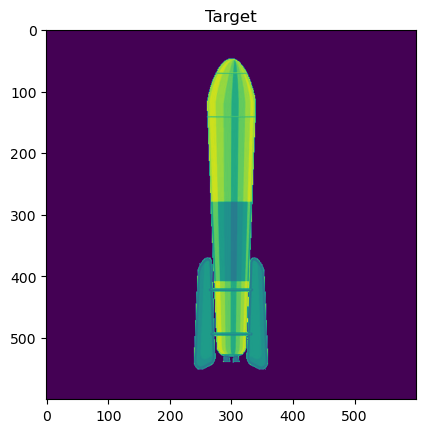

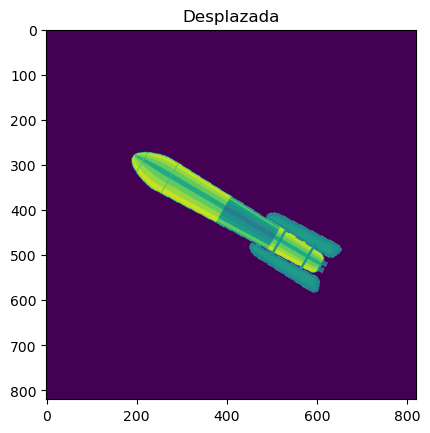

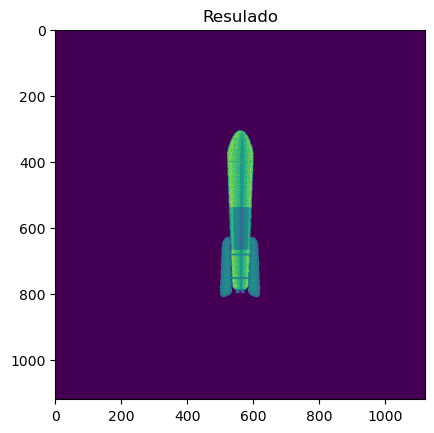

theta=  60
iteraciones=  3
Iteracion de error=  [0.04594607091813175, 0.024792926779847135, 0.013812965727014724, 0.002118510482637854]


In [8]:
resultado = rotacion(img_des, theta) 

plt.imshow(img_or)
plt.title('Target')
plt.show()

plt.imshow(img_des)
plt.title('Desplazada')
plt.show()

plt.imshow(resultado)
plt.title('Resulado')
plt.show()

#cv2.imshow("Original", img_or)
#cv2.imshow('Desplazada', img_des)
#cv2.imshow('Resultado', resultado)

print("theta= ",theta)
print("iteraciones= ",it)
print("Iteracion de error= ",err_l)

cv2.waitKey()
cv2.destroyAllWindows()   

# 2- Alinear imagen con algoritmo basado en RANSAC

Importar paquetes y funcion de recta

In [9]:
import cv2
import numpy as np
import math
from ipynb.fs.full.recta import *

Datos de entrada

In [10]:
img = cv2.imread('Imagenes/escalera_fija.jpeg')
imgDes = cv2.imread('Imagenes/escalera_des.jpeg')

height, width = img.shape[:2]

imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
imgDesGray = cv2.cvtColor(imgDes, cv2.COLOR_BGR2GRAY) 

Deteccion de puntos con SIFT

In [11]:
sift = cv2.SIFT_create()
hp = sift.detect(imgGray,None)
imgHP=cv2.drawKeypoints(imgGray,hp,imgGray)

hpDes = sift.detect(imgDesGray,None)
imgDesHP=cv2.drawKeypoints(imgDesGray,hpDes,imgDesGray)



Se llama a la funcion recta contiene un algoritmo basado en RANSAC para obtener la mejor recta sobre conjunto de puntos detectado.
La funcion retorna los coeficientes de la recta y recibe de entrada: lista de puntos, imagen para visualizar la recta, distancia y numero de iteraciones de RANSAC.
Se gráfican y se imprinen los coeficientes de las rectas seleccionadas 

x =  [306.51077271 232.77799988] y=  [399.70324707 201.76846313]
Puntos totales=  160
a = 2.6844885435078503
b = -423.1214107182083


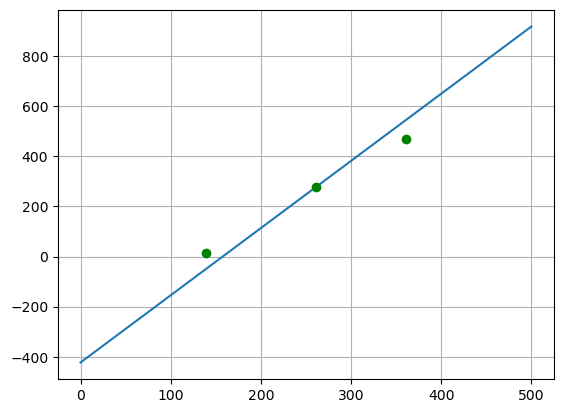

x =  [272.90893555  21.46269989] y=  [244.42778015 334.13775635]
Puntos totales=  172
a = -0.3567759762319791
b = 341.7951320535338


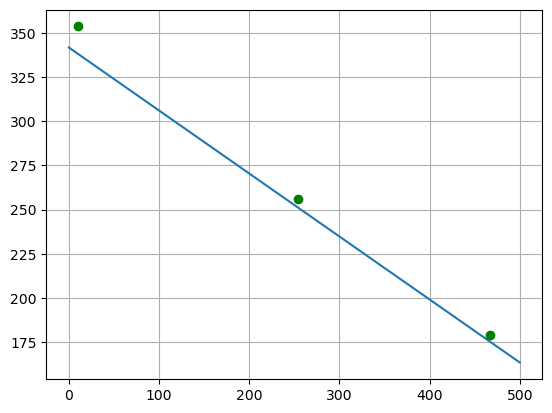

zeta= [   2.68448854 -423.12141072]
zeta2= [ -0.35677598 341.79513205]


In [12]:
z=recta(hp, imgHP, 20, 750) #Para distancia margen =20 y 00 iteraciones
zD=recta(hpDes, imgDesHP, 20, 750) #Para distancia margen =20 y 00 iteraciones
print('zeta=', z)
print('zeta2=', zD)

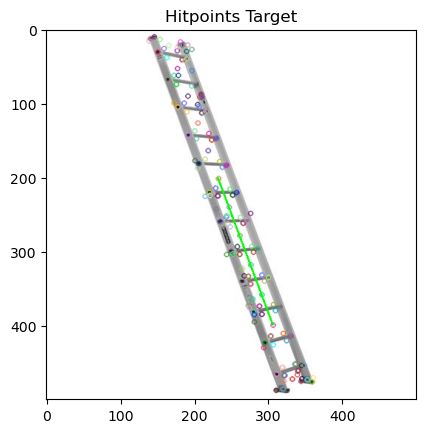

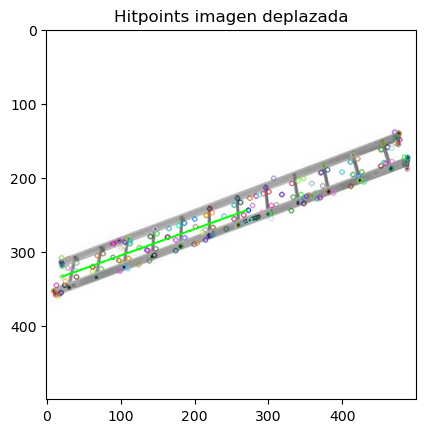

In [13]:
plt.imshow(imgHP)
plt.title('Hitpoints Target')
plt.show()

plt.imshow(imgDesHP)
plt.title('Hitpoints imagen deplazada')
plt.show()

Se calcula el angulo entre las dos rectas:

$\theta = arctan(\frac{m_{1} - m_{2}}{1 + m_{1}*m_{2}})$

In [14]:
#Tanθ = m1−m2 / 1+m1.m2
angulo = abs(np.arctan((z[0] - zD[0]) * (1.0/ (1+ (z[0]*zD[0])))))  * (180/np.pi)

print('angulo= ', angulo)


angulo=  89.2042916249803


Se rota la imagen desplazada y se muestra el resultado

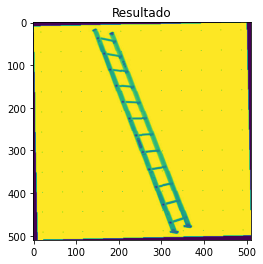

In [14]:
imgDesGray=rotacion(imgDesGray, angulo)

plt.imshow(imgDesGray)
plt.title('Resultado')
plt.show()

# 3 - Registro nube de puntos

In [15]:
import cv2
import numpy as np
import open3d as o3d
import copy
from scipy.spatial.distance import directed_hausdorff

Leer datos y asignarle un color uniforme

In [16]:
pcd = o3d.io.read_point_cloud('Imagenes/dragon_fijo.ply')
pcd2 = o3d.io.read_point_cloud('Imagenes/dragon_des.ply')

pcd.paint_uniform_color([1, 0.5, 0])
pcd2.paint_uniform_color([0, 0.651, 0.929])

PointCloud with 100250 points.

Matriz de transformacion inicial y threshold

In [17]:
trans_matrix = np.asarray([[1.0, 0.0, 0.0, 0.],
                             [0.0, 1.0, 0.0, 0.0],
                             [0.0, 0.0, 1.0, 0.0], 
                             [0.0, 0.0, 0.0, 1.0]])

Aplicar algoritmo de Iterative Closest Point con función, imprimir matriz de transformacion resultante

In [18]:
reg_p2p = o3d.pipelines.registration.registration_icp(pcd2, pcd, 0.009, trans_matrix,o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Matriz de transformacion:")
print(reg_p2p.transformation)
print("")

RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.164588e-03, and correspondence_set size of 100250
Access transformation to get result.
Matriz de transformacion:
[[ 9.82626509e-01  1.85094433e-01  1.36086113e-02  1.29275536e-03]
 [-1.84998976e-01  9.82706328e-01 -7.97826514e-03 -1.63432211e-04]
 [-1.48500009e-02  5.32207567e-03  9.99875569e-01 -6.95582978e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]



Transformar nube de puntos desplazada

In [19]:
pcd2.transform(reg_p2p.transformation)

PointCloud with 100250 points.

Calcular distancia de Hausdorff con funcion

In [20]:
haus=directed_hausdorff(pcd2.points, pcd.points)
print('Distancia Hausdorf: ', haus[0])

Distancia Hausdorf:  0.004242925161647543


Desplegar las dos nubes de puntos

In [ ]:
 o3d.visualization.draw_geometries([pcd, pcd2])